In [1]:
import os
import glob
import re

import pandas as pd
pd.options.display.max_columns = None
pd.options.display.max_rows = 600
import numpy as np
from matplotlib_venn import venn3, venn3_circles
import matplotlib.pyplot as plt

In [2]:
id_map = pd.read_csv('/cephfs/users/annawoodard/gene-fusion/WABCS-U01_Samples_Phenotype_master2B.csv')

def parse_data(path):
    df = pd.read_table(path)
    sample = path.split('/')[7]
    patient = id_map[id_map['NGDx RNAseq Lib ID'] == sample[:-2]]['NBCS barcode'].iloc[0]
    
    df['sample'] = sample
    df['patient'] = patient
    
    return df

In [3]:
files = glob.glob('/cephfs/users/annawoodard/gene-fusion/starseqr/results_v3/*/ss_STAR-SEQR/ss_STAR-SEQR_candidates.txt')
dfs = [parse_data(f) for f in files]
starseqr_data = pd.concat(dfs)
starseqr_data = starseqr_data[starseqr_data['DISPOSITION'] == 'PASS']
starseqr_data['gene1'] = starseqr_data['LEFT_SYMBOL']
starseqr_data['gene2'] = starseqr_data['RIGHT_SYMBOL']
starseqr_data['chromosome1'] = starseqr_data.BRKPT_LEFT.str.extract(pat='(^\d.*)\:\d.*\:.*')
starseqr_data['chromosome2'] = starseqr_data.BRKPT_RIGHT.str.extract(pat='(^\d.*)\:\d.*\:.*')
# Transformation below is because starseqr is 0-indexed while the other callers are 1-indexed
starseqr_data['breakpoint1'] = starseqr_data.BRKPT_LEFT.str.extract(pat='^\d.*\:(\d.*)\:.*').astype(float).astype('Int64') + 1
starseqr_data.breakpoint1 = starseqr_data.chromosome1 + ':' + starseqr_data.breakpoint1.astype(str)
starseqr_data['breakpoint2'] = starseqr_data.BRKPT_RIGHT.str.extract(pat='^\d.*\:(\d.*)\:.*').astype(float).astype('Int64') + 1
starseqr_data.breakpoint2 = starseqr_data.chromosome2 + ':' + starseqr_data.breakpoint2.astype(str)
starseqr_data['name'] = starseqr_data[['gene1', 'gene2']].apply(lambda x: '--'.join(sorted(x)), axis=1)
starseqr_data['junction_reads'] = starseqr_data.NREAD_JXNLEFT + starseqr_data.NREAD_JXNRIGHT
starseqr_data['spanning_reads'] = starseqr_data.NREAD_SPANS
starseqr_data['starseqr'] = True

In [4]:
files = glob.glob('/cephfs/users/annawoodard/gene-fusion/arriba/results_v3/*/fusions.tsv')
dfs = [parse_data(f) for f in files]
arriba_data = pd.concat(dfs)
arriba_data[arriba_data.confidence.str.contains('medium|high')]
arriba_data.rename(columns={'#gene1': 'gene1'}, inplace=True)
arriba_data['name'] = arriba_data[['gene1', 'gene2']].apply(lambda x: '--'.join(sorted(x)), axis=1)
arriba_data['junction_reads'] = arriba_data.split_reads1 + arriba_data.split_reads2
arriba_data['spanning_reads'] = arriba_data.discordant_mates
arriba_data['arriba'] = True

In [5]:
files = glob.glob('/cephfs/users/annawoodard/gene-fusion/star-fusion/results_v3/*/star-fusion.fusion_predictions.tsv')
dfs = [parse_data(f) for f in files]
starfusion_data = pd.concat(dfs)
#starfusion_data.rename(columns={'#FusionName': 'name'}, inplace=True)
starfusion_data['breakpoint1'] = starfusion_data['LeftBreakpoint'].str.rstrip('\:\+|\:\-').str.lstrip('chr')
starfusion_data['breakpoint2'] = starfusion_data['RightBreakpoint'].str.rstrip('\:\+|\:\-').str.lstrip('chr')
pattern = re.compile(r'\^.*')
starfusion_data['gene1'] = starfusion_data.LeftGene.str.replace(pattern, '')
starfusion_data['gene2'] = starfusion_data.RightGene.str.replace(pattern, '')
starfusion_data['name'] = starfusion_data[['gene1', 'gene2']].apply(lambda x: '--'.join(sorted(x)), axis=1)
starfusion_data['junction_reads'] = starfusion_data['JunctionReadCount']
starfusion_data['spanning_reads'] = starfusion_data['SpanningFragCount']
starfusion_data['starfusion'] = True

In [6]:
starfusion_data[starfusion_data.name == 'OR51S1--TP53I11'].sort_values(['FFPM'], ascending=False)

,#FusionName,JunctionReadCount,SpanningFragCount,SpliceType,LeftGene,LeftBreakpoint,RightGene,RightBreakpoint,JunctionReads,SpanningFrags,LargeAnchorSupport,FFPM,LeftBreakDinuc,LeftBreakEntropy,RightBreakDinuc,RightBreakEntropy,annots,sample,patient,breakpoint1,breakpoint2,gene1,gene2,name,junction_reads,spanning_reads,starfusion
5,OR51S1--TP53I11,14,0,INCL_NON_REF_SPLICE,OR51S1^ENSG00000176922.4,chr11:4848669:-,TP53I11^ENSG00000175274.18,chr11:44933050:-,NRUSCA-WDL30529:156:C95L0ANXX:7:1316:1206:2615...,.,YES_LDAS,0.2822,GT,1.8295,AG,1.4256,"[""INTRACHROMOSOMAL[chr11:40.04Mb]""]",LIB-008196wt,NWRONGID2_WAS_N011063,11:4848669,11:44933050,OR51S1,TP53I11,OR51S1--TP53I11,14,0,True
3,OR51S1--TP53I11,3,0,INCL_NON_REF_SPLICE,OR51S1^ENSG00000176922.4,chr11:4848669:-,TP53I11^ENSG00000175274.18,chr11:44933050:-,NRUSCA-WDL30342:282:H3J57ADXY:1:2116:19993:450...,.,YES_LDAS,0.2701,GT,1.8295,AG,1.4256,"[""INTRACHROMOSOMAL[chr11:40.04Mb]""]",LIB-006798wt,Unknown,11:4848669,11:44933050,OR51S1,TP53I11,OR51S1--TP53I11,3,0,True
14,OR51S1--TP53I11,13,0,INCL_NON_REF_SPLICE,OR51S1^ENSG00000176922.4,chr11:4848669:-,TP53I11^ENSG00000175274.18,chr11:44933050:-,NRUSCA-WDL30529:156:C95L0ANXX:2:2105:4485:7743...,.,YES_LDAS,0.2476,GT,1.8295,AG,1.4256,"[""INTRACHROMOSOMAL[chr11:40.04Mb]""]",LIB-008182wt,L000024,11:4848669,11:44933050,OR51S1,TP53I11,OR51S1--TP53I11,13,0,True
5,OR51S1--TP53I11,7,0,INCL_NON_REF_SPLICE,OR51S1^ENSG00000176922.4,chr11:4848669:-,TP53I11^ENSG00000175274.18,chr11:44933050:-,NRUSCA-WDL30445:153:C8755ANXX:8:2314:3296:8361...,.,YES_LDAS,0.2203,GT,1.8295,AG,1.4256,"[""INTRACHROMOSOMAL[chr11:40.04Mb]""]",LIB-04590wt,NWRONGID_WAS_N011024,11:4848669,11:44933050,OR51S1,TP53I11,OR51S1--TP53I11,7,0,True
22,OR51S1--TP53I11,16,0,INCL_NON_REF_SPLICE,OR51S1^ENSG00000176922.4,chr11:4848669:-,TP53I11^ENSG00000175274.18,chr11:44933050:-,NRUSCA-WDL30529:156:C95L0ANXX:2:2310:8410:6740...,.,YES_LDAS,0.2108,GT,1.8295,AG,1.4256,"[""INTRACHROMOSOMAL[chr11:40.04Mb]""]",LIB-008188wt,NWRONGID1_WAS_N011067,11:4848669,11:44933050,OR51S1,TP53I11,OR51S1--TP53I11,16,0,True
4,OR51S1--TP53I11,12,0,INCL_NON_REF_SPLICE,OR51S1^ENSG00000176922.4,chr11:4848669:-,TP53I11^ENSG00000175274.18,chr11:44933050:-,NRUSCA-WDL30529:127:C7A7UANXX:2:1116:18425:242...,.,YES_LDAS,0.2084,GT,1.8295,AG,1.4256,"[""INTRACHROMOSOMAL[chr11:40.04Mb]""]",LIB-04615wt,N010861,11:4848669,11:44933050,OR51S1,TP53I11,OR51S1--TP53I11,12,0,True
10,OR51S1--TP53I11,24,0,INCL_NON_REF_SPLICE,OR51S1^ENSG00000176922.4,chr11:4848669:-,TP53I11^ENSG00000175274.18,chr11:44933050:-,NRUSCA-WDL30529:128:C7842ANXX:7:1215:4223:4767...,.,YES_LDAS,0.1947,GT,1.8295,AG,1.4256,"[""INTRACHROMOSOMAL[chr11:40.04Mb]""]",LIB-04658wt,L000050,11:4848669,11:44933050,OR51S1,TP53I11,OR51S1--TP53I11,24,0,True
3,OR51S1--TP53I11,9,0,INCL_NON_REF_SPLICE,OR51S1^ENSG00000176922.4,chr11:4848669:-,TP53I11^ENSG00000175274.18,chr11:44933050:-,NRUSCA-WDL30445:153:C8755ANXX:7:2106:11854:396...,.,YES_LDAS,0.1906,GT,1.8295,AG,1.4256,"[""INTRACHROMOSOMAL[chr11:40.04Mb]""]",LIB-04618wt,N010870,11:4848669,11:44933050,OR51S1,TP53I11,OR51S1--TP53I11,9,0,True
6,OR51S1--TP53I11,7,0,INCL_NON_REF_SPLICE,OR51S1^ENSG00000176922.4,chr11:4848669:-,TP53I11^ENSG00000175274.18,chr11:44933050:-,NRUSCA-WDL30529:156:C95L0ANXX:2:1309:1685:6410...,.,YES_LDAS,0.1905,GT,1.8295,AG,1.4256,"[""INTRACHROMOSOMAL[chr11:40.04Mb]""]",LIB-008178wt,L000020,11:4848669,11:44933050,OR51S1,TP53I11,OR51S1--TP53I11,7,0,True
8,OR51S1--TP53I11,10,0,INCL_NON_REF_SPLICE,OR51S1^ENSG00000176922.4,chr11:4848669:-,TP53I11^ENSG00000175274.18,chr11:44933050:-,NRUSCA-WDL30445:134:C636BACXX:4:2309:20422:863...,.,YES_LDAS,0.1865,GT,1.8295,AG,1.4256,"[""INTRACHROMOSOMAL[chr11:40.04Mb]""]",LIB-03335WT,N010898,11:4848669,11:44933050,OR51S1,TP53I11,OR51S1--TP53I11,10,0,True


In [7]:
starfusion_data[starfusion_data.annots.str.contains('GTEx_recurrent_StarF2019')]['annots']

5    ["GTEx_recurrent_StarF2019","ChimerKB","INTERC...
6    ["GTEx_recurrent_StarF2019","ChimerKB","INTERC...
7    ["GTEx_recurrent_StarF2019","ChimerKB","INTERC...
8    ["GTEx_recurrent_StarF2019","ChimerKB","INTERC...
9    ["GTEx_recurrent_StarF2019","ChimerKB","INTERC...
0    ["GTEx_recurrent_StarF2019","ChimerKB","INTERC...
1    ["GTEx_recurrent_StarF2019","ChimerKB","INTERC...
2    ["GTEx_recurrent_StarF2019","ChimerKB","INTERC...
Name: annots, dtype: object

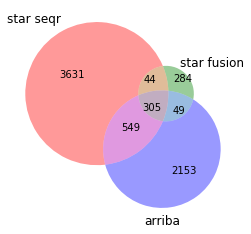

In [8]:
unique_starseqr = set(starseqr_data.name.tolist())
unique_starfusion = set(starfusion_data.name.tolist())
unique_arriba = set(arriba_data.name.tolist())

venn3([unique_starseqr, unique_starfusion, unique_arriba], set_labels = ('star seqr', 'star fusion', 'arriba'))
#plt.savefig('plots/fail_DBSNP_ppon_1kgenomes_venn.pdf', bbox_inches='tight')

In [9]:
data = pd.concat([arriba_data, starseqr_data, starfusion_data], sort=False)

#data.fillna({'arriba': False, 'starseqr': False, 'starfusion': False}, inplace=True)
data[['gene1', 'gene2', 'breakpoint1', 'breakpoint2', 'arriba', 'starseqr', 'starfusion']]
#data.columns

,gene1,gene2,breakpoint1,breakpoint2,arriba,starseqr,starfusion
0,RP11-813C7.1,RBMS1,2:160169212,2:160303487,True,NaN,NaN
1,RP11-813C7.1,RBMS1,2:160172569,2:160303487,True,NaN,NaN
2,ITGB6,RBMS1,2:160169212,2:160303487,True,NaN,NaN
3,ITGB6,RBMS1,2:160172569,2:160303487,True,NaN,NaN
4,STARD3,AC087491.2,17:39637231,17:39622205,True,NaN,NaN
...,...,...,...,...,...,...,...
3,ZSWIM4,ZNF627,19:13805148,19:11575250,NaN,NaN,True
4,OR51S1,TP53I11,11:4848669,11:44933050,NaN,NaN,True
0,ARL5B,AC008691.1,10:18659683,5:159786092,NaN,NaN,True
1,TMEM204,HTRA2,16:1534555,2:74532619,NaN,NaN,True


In [17]:
for patient in data[data.name == 'EDDM13--ZNF71']['patient'].unique():
    print(data[(data.name == 'EDDM13--ZNF71') & (data.patient == patient)][['patient', 'breakpoint1', 'breakpoint2', 'arriba', 'starseqr', 'starfusion']])

     patient  breakpoint1  breakpoint2 arriba starseqr starfusion
2    L000204  19:56617076  19:56304774   True      NaN        NaN
3    L000204  19:56601591  19:56304774   True      NaN        NaN
4    L000204  19:56613938  19:56304774   True      NaN        NaN
116  L000204  19:56613938  19:56304774    NaN     True        NaN
7    L000204  19:56601591  19:56304774    NaN      NaN       True
     patient  breakpoint1  breakpoint2 arriba starseqr starfusion
7    L000203  19:56617076  19:56304774   True      NaN        NaN
8    L000203  19:56613938  19:56304774   True      NaN        NaN
9    L000203  19:56601591  19:56304774   True      NaN        NaN
137  L000203  19:56613938  19:56304774    NaN     True        NaN
5    L000203  19:56613938  19:56304774    NaN      NaN       True
7    L000203  19:56601591  19:56304774    NaN      NaN       True
     patient  breakpoint1  breakpoint2 arriba starseqr starfusion
1    L000024  19:56617076  19:56304774   True      NaN        NaN
2    L0000

In [11]:
callers = ['arriba', 'starseqr', 'starfusion']

In [12]:
data.columns

Index(['gene1', 'gene2', 'strand1(gene/fusion)', 'strand2(gene/fusion)',
       'breakpoint1', 'breakpoint2', 'site1', 'site2', 'type', 'direction1',
       'direction2', 'split_reads1', 'split_reads2', 'discordant_mates',
       'coverage1', 'coverage2', 'confidence', 'closest_genomic_breakpoint1',
       'closest_genomic_breakpoint2', 'filters', 'fusion_transcript',
       'reading_frame', 'peptide_sequence', 'read_identifiers', 'sample',
       'patient', 'name', 'junction_reads', 'spanning_reads', 'arriba', 'NAME',
       'NREAD_SPANS', 'NREAD_JXNLEFT', 'NREAD_JXNRIGHT', 'FUSION_CLASS',
       'SPLICE_TYPE', 'BRKPT_LEFT', 'BRKPT_RIGHT', 'LEFT_SYMBOL',
       'RIGHT_SYMBOL', 'ANNOT_FORMAT', 'LEFT_ANNOT', 'RIGHT_ANNOT', 'DISTANCE',
       'ASSEMBLED_CONTIGS', 'ASSEMBLY_CROSS_JXN', 'PRIMERS', 'ID',
       'SPAN_CROSSHOM_SCORE', 'JXN_CROSSHOM_SCORE', 'OVERHANG_DIVERSITY',
       'MINFRAG20', 'MINFRAG35', 'OVERHANG_MEANBQ', 'SPAN_MEANBQ',
       'JXN_MEANBQ', 'OVERHANG_BQ15', 'SPAN_BQ15

In [13]:
len(unique_starfusion), len(unique_starseqr), len(unique_arriba)

(682, 4529, 3056)

In [14]:
# Use 'ensemble' approach: accept any fusion if it is called by at least two callers
# This approach is extremely slow-- need to figure out how to vectorize

mask = []
for index, row in data[['name', 'sample', 'patient'] + callers].iterrows():
    subset = data[(data.name == row['name']) & (data['sample'] == row['sample']) & (data.patient == row['patient'])]
    mask.append((int(np.any(subset.arriba)) + int(np.any(subset.starseqr)) + int(np.any(subset.starfusion))) > 1)

In [15]:
data[mask]

,gene1,gene2,strand1(gene/fusion),strand2(gene/fusion),breakpoint1,breakpoint2,site1,site2,type,direction1,direction2,split_reads1,split_reads2,discordant_mates,coverage1,coverage2,confidence,closest_genomic_breakpoint1,closest_genomic_breakpoint2,filters,fusion_transcript,reading_frame,peptide_sequence,read_identifiers,sample,patient,name,junction_reads,spanning_reads,arriba,NAME,NREAD_SPANS,NREAD_JXNLEFT,NREAD_JXNRIGHT,FUSION_CLASS,SPLICE_TYPE,BRKPT_LEFT,BRKPT_RIGHT,LEFT_SYMBOL,RIGHT_SYMBOL,ANNOT_FORMAT,LEFT_ANNOT,RIGHT_ANNOT,DISTANCE,ASSEMBLED_CONTIGS,ASSEMBLY_CROSS_JXN,PRIMERS,ID,SPAN_CROSSHOM_SCORE,JXN_CROSSHOM_SCORE,OVERHANG_DIVERSITY,MINFRAG20,MINFRAG35,OVERHANG_MEANBQ,SPAN_MEANBQ,JXN_MEANBQ,OVERHANG_BQ15,SPAN_BQ15,JXN_BQ15,OVERHANG_MM,SPAN_MM,JXN_MM,OVERHANG_MEANLEN,SPAN_MEANLEN,JXN_MEANLEN,TPM_FUSION,TPM_LEFT,TPM_RIGHT,MAX_TRX_FUSION,DISPOSITION,chromosome1,chromosome2,starseqr,#FusionName,JunctionReadCount,SpanningFragCount,SpliceType,LeftGene,LeftBreakpoint,RightGene,RightBreakpoint,JunctionReads,SpanningFrags,LargeAnchorSupport,FFPM,LeftBreakDinuc,LeftBreakEntropy,RightBreakDinuc,RightBreakEntropy,annots,starfusion
2,ITGB6,RBMS1,-/-,-/-,2:160169212,2:160303487,splice-site,splice-site,duplication,upstream,downstream,22,106,65,807,374,high,.,.,"duplicates(95),low_entropy(11),mismappers(1)",AATGACTCCCTCCACCTCCTGGTCTTTGTGAGTGATGCTGATTCTC...,in-frame,NDSLHLLVFVSDADSHFGMDSKLAGIVIPNDGLCHLDSKNEYSMST...,.,LIB-03335WT,N010898,ITGB6--RBMS1,128,65,True,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,ITGB6,RBMS1,-/-,-/-,2:160172569,2:160303487,splice-site,splice-site,duplication,upstream,downstream,0,2,11,1050,374,high,.,.,duplicates(5),TGATGCAATTATGCAAGCTGCTGTGTGTAAG___GAAAAAATTGGC...,in-frame,DAIMQAAVCKEKIGWRNDSLHLLVFVSDADSHFGMDSKLAGIVIPN...,.,LIB-03335WT,N010898,ITGB6--RBMS1,2,11,True,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,STARD3,AC087491.2,+/+,+/-,17:39637231,17:39622205,splice-site,exon,inversion/3'-3',downstream,downstream,11,108,4,2312,501,high,.,.,"duplicates(39),inconsistently_clipped(9)",CTTCGCTCTCGGGGGCGGACTCAGCGGCGGAAGTGGCGCTGCCGGA...,.,.,.,LIB-03335WT,N010898,AC087491.2--STARD3,119,4,True,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
6,STARD3,NEUROD2,+/+,-/-,17:39637231,17:39608065,splice-site,exon,inversion,downstream,downstream,1,30,2,2312,96,high,.,.,duplicates(9),GGCGGAAGTGGCGCTGCCGGAAGATCTTCTTCCGCTCTGAGGCGCT...,.,.,.,LIB-03335WT,N010898,NEUROD2--STARD3,31,2,True,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
7,STARD3,NEUROD2,+/+,-/-,17:39637231,17:39606604,splice-site,splice-site,inversion,downstream,downstream,2,10,1,2312,72,medium,.,.,duplicates(4),CCGCAGGCGAACGCAAGTCCCGCTTCGCTCTCGGGGGCGGACTCAG...,.,.,.,LIB-03335WT,N010898,NEUROD2--STARD3,12,1,True,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,

In [16]:
data[mask]['name'].nunique(), arriba_data.name.nunique(), starfusion_data.name.nunique(), starseqr_data.name.nunique()

(922, 3056, 682, 4529)

In [17]:
union = pd.concat([starseqr_data, arriba_data, starseqr_data], sort=False)

In [18]:
union['name'].nunique()

6731

In [19]:
union.to_parquet('/cephfs/users/annawoodard/gene-fusion/data/processed/fusion_union.parquet')

In [64]:
# Alternate 'ensemble' approach: accept any fusion if it is called by starfusion, or both starseqr and arriba
# This approach is extremely slow-- need to figure out how to vectorize
mask = []
for index, row in data[['name', 'sample', 'patient'] + callers].iterrows():
    if row.starfusion == True:
        mask.append(True)
    else:
        subset = data[(data.name == row['name']) & (data['sample'] == row['sample']) & (data.patient == row['patient'])]
        mask.append((int(np.any(subset.arriba)) + int(np.any(subset.starseqr)) > 1))

In [95]:
data[mask][['name']].drop_duplicates().to_csv('/cephfs/users/annawoodard/gene-fusion/data/interim/fusions.tsv', sep='\t', index=False)

In [96]:
!docker run -v /cephfs/users/annawoodard/gene-fusion/GRCh38_gencode_v31_CTAT_lib_Oct012019.plug-n-play/ctat_genome_lib_build_dir:/ctat_genome_lib_build_dir -v /cephfs/users/annawoodard/gene-fusion/data/interim/fusions.tsv:/fusions.tsv trinityctat/starfusion:1.8.0 /usr/local/src/STAR-Fusion/FusionInspector/FusionAnnotator/FusionAnnotator --annotate /fusions.tsv --full --genome_lib_dir /ctat_genome_lib_build_dir/ > /cephfs/users/annawoodard/gene-fusion/data/interim/annotated_fusions.tsv

In [20]:
annotated_fusions = pd.read_csv('/cephfs/users/annawoodard/gene-fusion/data/interim/annotated_fusions.tsv', sep='\t', skiprows=1, header=None, names=['name', 'annotations'])

In [21]:
annotated_fusions

,name,annotations
0,ITGB6--RBMS1,"{""ITGB6--RBMS1"":{""LOCALITY"":[""INTRACHROMOSOMAL..."
1,AC087491.2--STARD3,{}
2,NEUROD2--STARD3,"{""NEUROD2--STARD3"":{""LOCALITY"":[""INTRACHROMOSO..."
3,CDK12--FBXL20,"{""CDK12--FBXL20"":{""LOCALITY"":[""INTRACHROMOSOMA..."
4,MYO18A--RNF213,{}
...,...,...
917,PRKAA1--RAI14,"{""PRKAA1--RAI14"":{""LOCALITY"":[""INTRACHROMOSOMA..."
918,IMMP2L--PWWP2B,"{""IMMP2L--PWWP2B"":{""LOCALITY"":[""INTERCHROMOSOM..."
919,NCOA2--SH3YL1,"{""NCOA2--SH3YL1"":{""LOCALITY"":[""INTERCHROMOSOMA..."
920,ZNF627--ZSWIM4,"{""ZNF627--ZSWIM4"":{""LOCALITY"":[""INTRACHROMOSOM..."


In [22]:
data['annotations'] = ''
for index, row in annotated_fusions.iterrows():
    data.loc[data.name == row['name'], 'annotations'] = row['annotations']

In [ ]:
cutflow = {}

# tcga.normal.id appears to be identical list
tcga_normal = pd.read_table('/cephfs/users/annawoodard/gene-fusion/CPTAC3-RNA-related-pipeline/FilterDatabase/tcga.normal.txt', names=['cancer', 'sample', 'fusion'])
cutflow['tcga normal'] = data.loc[data['name'].isin(tcga_normal.fusion), 'name']

noncancer_cell = pd.read_table('/cephfs/users/annawoodard/gene-fusion/CPTAC3-RNA-related-pipeline/FilterDatabase/noncancer_cell.txt', names=['fusion'])
cutflow['noncancer cell'] = data.loc[data['name'].isin(noncancer_cell.fusion), 'name']

gtex_or_paralogue = pd.read_table('/cephfs/users/annawoodard/gene-fusion/CPTAC3-RNA-related-pipeline/FilterDatabase/blacklist.manual', names=['fusion'])
cutflow['gtex or paralogue'] = data.loc[data['name'].isin(gtex_or_paralogue.fusion), 'name']

items = cutflow.items()
venn3([set(values) for key, values in items], set_labels = [key for key, values in items])
plt.title('unique fusions filtered')

In [23]:
cutflow = {}
cutflow['HLA'] = data[data.name.str.contains('HLA')].name.unique().tolist()
cutflow['ChrM'] = data[data.annotations.str.contains('ChrM')].name.unique().tolist()
cutflow['GTEx_recurrent_StarF2019'] = data[data.annotations.str.contains('GTEx_recurrent_StarF2019')].name.unique().tolist()
cutflow['DGD_PARALOGS'] = data[data.annotations.str.contains('DGD_PARALOGS')].name.unique().tolist()
cutflow['HGNC_GENEFAM'] = data[data.annotations.str.contains('HGNC_GENEFAM')].name.unique().tolist()
cutflow['Greger_Normal'] = data[data.annotations.str.contains('Greger_Normal')].name.unique().tolist()
cutflow['Babiceanu_Normal'] = data[data.annotations.str.contains('Babiceanu_Normal')].name.unique().tolist()
cutflow['ConjoinG'] = data[data.annotations.str.contains('ConjoinG')].name.unique().tolist()
cutflow['blast'] = data[data.annotations.str.contains('BLAST')].name.unique().tolist()

In [66]:
cutflow

{'HLA': ['HLA-G--SRPK1',
  'HCG4P7--HLA-A',
  'DTX2--HLA-DQB1',
  'HLA-DPA1--HLA-DRB1',
  'HLA-DQA1--HLA-DRB1',
  'HLA-E--HLA-F',
  'HLA-DQA1--HLA-DQB1',
  'HLA-B--ITGA5',
  'HLA-B--HLA-H',
  'HLA-G--HLA-H',
  'HLA-DRA--RPL17-C18orf32',
  'HLA-B--PSORS1C1'],
 'ChrM': [],
 'GTEx_recurrent_StarF2019': ['DNAJC6--PDE1C'],
 'DGD_PARALOGS': ['SPNS2--SPNS3',
  'PLCB1--PLCB4',
  'CHRNA3--CHRNA5',
  'KRT17--KRT19'],
 'HGNC_GENEFAM': ['ZNF567--ZNF836',
  'PPFIA1--SHANK2',
  'GAS5--MALAT1',
  'SCGB1D2--SCGB2A2',
  'CHRNA3--CHRNA5',
  'HIST2H2BD--HIST2H4A',
  'ANKFN1--ITGB4',
  'KRT17--KRT19',
  'CDH1--CDH3'],
 'Greger_Normal': [],
 'Babiceanu_Normal': [],
 'ConjoinG': [],
 'blast': ['KRT17--KRT19']}

In [25]:
print('{} fusions ({} unique) filtered / {} unique total fusions'.format(
    sum([len(values) for values in cutflow.values()]),
    sum([len(set(values)) for values in cutflow.values()]),
    data.name.nunique()
    )
)

27 fusions (27 unique) filtered / 7015 unique total fusions


In [26]:
mask = mask & ~data.name.isin(sum(cutflow.values(), []))

In [61]:
subtypes = pd.read_csv('/cephfs/users/annawoodard/gene-fusion/data/external/Perou_Nigeria_109_samples_PAM50_Calls_9-12-19_UPDATED_9-21-19-PSR.csv')

dupe_samples = [
    'LIB-04604wt',
    'LIB-04626wt',
    'LIB-04662wt',
    'LIB-04629wt',
    'LIB-04609wt',
    'LIB-04660wt',
    'LIB-04623wt',
    'LIB-04607wt',
    'LIB-04630wt',
    'LIB-04622wt',
    'LIB-03328WT',
    'LIB-04661wt',
    'LIB-04588wt'
]

subtypes = subtypes[~subtypes['RNAseq_name'].str.contains('|'.join(dupe_samples))]

pass_QC = (
    ~data.patient.str.contains('Unknown') &
    ~data.patient.str.contains('K562') &
    ~data.patient.str.contains('WRONG') &
    data['sample'].isin(subtypes['RNAseq_name'])  # TODO: double check, not sure if this is necessary-- removes two patients
)

print('{} unique fusions that pass QC; {} fusions that fail QC'.format(
    data[pass_QC]['name'].nunique(),
    data[~pass_QC]['name'].nunique()
    )
)

mask = mask & pass_QC

5541 unique fusions that pass QC; 1833 fusions that fail QC


In [62]:
sample_info

,patient_ID,sample_name,HER2_status_SheilaDoc,ER_status_SheilaDoc,PR_status_SheilaDoc,class_SheilaDoc,subtype_SheilaDoc,subtype_NatureComm
0,L000006,LIB-006815,HER2-,ER-,PR-,TNBC,Her2,Her2
1,L000009,LIB-007621,HER2-,ER-,PR-,TNBC,LumA,LumA
2,L000011,LIB-008184,HER2+,ER+,PR+,HER2+_ER+,Normal,LumB
3,L000013,LIB-008179,HER2+,ER-,PR-,HER2+_ER-,Basal,Basal
4,L000015,LIB-008183,HER2+,ER+,PR-,HER2+_ER+,Her2,Her2
5,L000017,LIB-008185,HER2-,ER-,PR-,TNBC,Basal,Her2
6,L000020,LIB-008178,HER2+,ER-,PR-,HER2+_ER-,Her2,Her2
7,L000024,LIB-008182,HER2+,ER-,PR-,HER2+_ER-,Basal,Basal
8,L000050,LIB-04658,HER2-,ER+,PR+,ER+_HER2-,LumA,LumA
9,L000052,LIB-03320,HER2+,ER-,PR-,HER2+_ER-,Her2,Her2


In [63]:
data[mask].name.nunique(), 

(704,)

In [64]:
data[pass_QC].patient.nunique(), data[mask].patient.nunique()

(96, 86)

In [65]:
data[mask].to_parquet('/cephfs/users/annawoodard/gene-fusion/data/processed/fusions.parquet')

In [20]:
a = set([1, 2, 3, 9])
b = set([1, 4, 8, 9])
c = set([6, 2, 8, 9])
d = set([10, 11, 12, 13])
e = set([9, 11, 12, 13])

In [3]:
(a & b)

{1, 9}

In [4]:
(a & c)

{2, 9}

In [5]:
(a & b) | (a & c) | (b & c)

{1, 2, 8, 9}

In [6]:
import itertools

In [14]:
list(itertools.combinations([a, b, c, d], 3))

[({1, 2, 3, 9}, {1, 4, 8, 9}, {2, 6, 8, 9}),
 ({1, 2, 3, 9}, {1, 4, 8, 9}, {10, 11, 12, 13}),
 ({1, 2, 3, 9}, {2, 6, 8, 9}, {10, 11, 12, 13}),
 ({1, 4, 8, 9}, {2, 6, 8, 9}, {10, 11, 12, 13})]

In [9]:
a & b & c

{9}

In [15]:
def get_consensus(sets, quorum):
    intersections = [set.intersection(*items) for items in itertools.combinations(sets, quorum)]
    return set.union(*intersections)

In [16]:
get_consensus([a, b, c, d], 2)

{1, 2, 8, 9}

In [17]:
get_consensus([a, b, c, d], 3)

{9}

In [21]:
get_consensus([a, b, c, d, e], 4)

{9}

In [28]:
sets = [a, b, c, d, e]

In [32]:
list(itertools.combinations(sets, 1))


[({1, 2, 3, 9},),
 ({1, 4, 8, 9},),
 ({2, 6, 8, 9},),
 ({10, 11, 12, 13},),
 ({9, 11, 12, 13},)]